# Music Affinity Across Boundaries

Spotify, the leading online music streaming platform with over 381 Million users across 184 markets, maintains lists of the top 50 tracks for over 68 countries. The goal of this analysis is to determine if there are similarities or disimilarities between popular music accross geographic and social boundaries.

Our analysis will focus on the audio features of songs contained in these top 50 lists. These audio features are sourced either directly from Spotify or are obtained from our own music information retreval process on the audio previews Spotify provides for most songs.

### Data collection and transformation process

Data was collected using Spotify's API. Top 50 lists of track from each country were collected on a daily basis for over 30 days. These daily data dumps were then used to identify unique songs and then pull additional information using the API.

In [1]:
#Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Data Exploration

In [2]:
#Bring in data
df = pd.read_csv('lookups/all_track_audio_features.csv')

df.dropna(axis=0, inplace=True)

df_tracks = df[['track_id','duration_ms','update_dttm',
       'name', 'artist', 'album_img', 'preview_url', 'popularity','basic_kmeans_cluster','adv_kmeans_cluster']]

features = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo_x', 'time_signature', 'chroma', 'chroma_cens', 'mff',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
       'spectral_flatness', 'Spectral_Rolloff', 'poly_features', 'tonnetz',
       'ZCR', 'onset_strength', 'pitch', 'magnitude', 'tempo']


One of the first issues we need to overcome is the fact that songs can be shared across playlists/countries. As seen below, certain songs and artists are popular across the world.

In [3]:
df_pd = pd.read_csv('playlist_data/playlist_data.csv')

df_pd['unique_id'] = df_pd.country + '-' + df_pd.track_id

df_pd = df_pd.drop_duplicates(subset=['unique_id'])

df_pd = df_pd[['country', 'market', 'track_artist','track_name','track_id']]
df_pd = df_pd[df_pd.country != 'global']

df_cross = df_pd[['market','track_id']].groupby(by='track_id').count()
df_cross.reset_index(inplace=True)
df_cross.rename(columns={'market':'list_count'},inplace=True)

df_temp = df.merge(df_cross, on='track_id', how='left')



df_viz = df_temp.sort_values('list_count', ascending=False)
df_viz = df_viz[['name','artist','album_img','list_count']]
df_viz['song'] = df_viz.name + ' - ' + df_viz.artist
df_viz.drop_duplicates(subset=['song'], keep='first', inplace=True)


                          

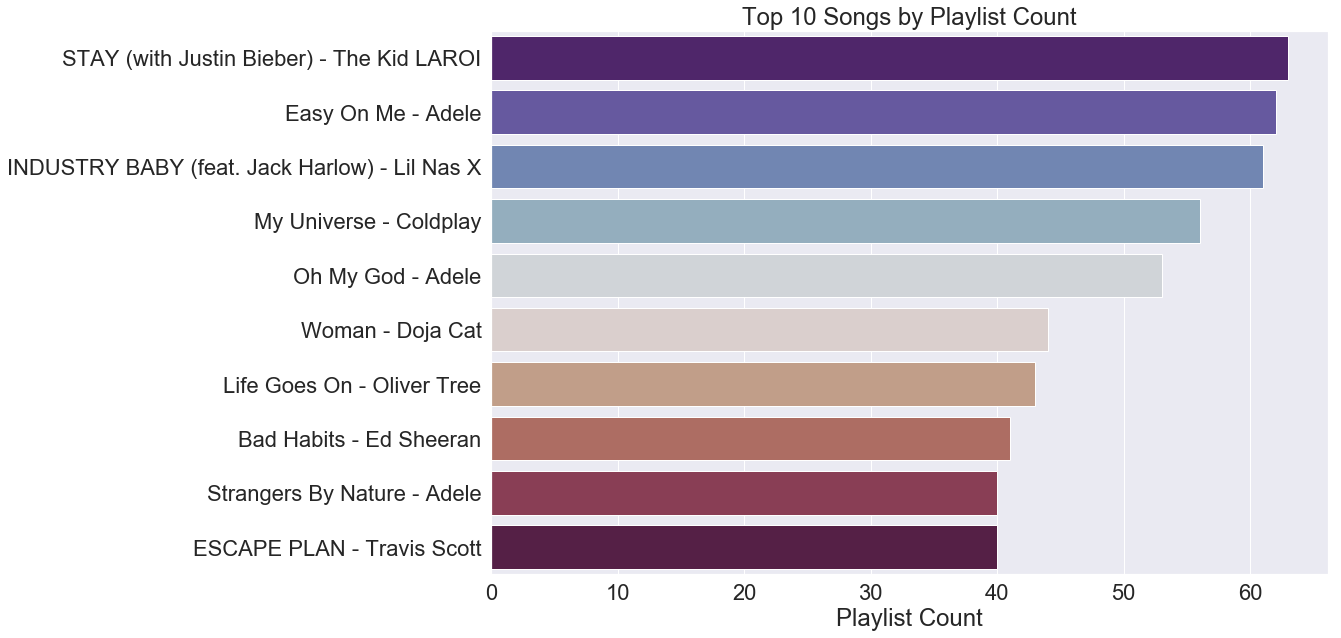

In [4]:
sb.set(font_scale=2)
fig, ax = plt.subplots(figsize=(15,10))
ax = sb.barplot(x='list_count', y='song', data=df_viz.head(10), palette='twilight_shifted')
ax.set_xlabel('Playlist Count')
ax.set_ylabel(None)
ax.set_title('Top 10 Songs by Playlist Count')

plt.show()


This may lend creedence to the assertion that music tastes are similar across boundaries. However, we want to develop a complete picture of a country's musical taste. In order to do this, we need to capture the average feature for a playlist across all songs it contains.

### Exploring Patterns of Countries Using K-Means Clustering

In [5]:
c_feat = {}

for ctry in df_pd.country.tolist():
    tracks = df_pd[df_pd['country']==ctry].track_id.tolist()
    df_temp = df[df.track_id.isin(tracks)]
    c_feat[ctry] = df_temp[features].mean(axis=0).tolist()
    
df_ctry_feat = pd.DataFrame.from_dict(c_feat, orient='index', columns=features)

In [7]:
#create kmeans clusters
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X = df_ctry_feat.drop(columns=['tempo_x'])
X = scaler.fit_transform(X)
inert = []
sil = []
axis = []

#Gather scores for a range of cluster counts in order to evaluate
for i, n in enumerate(range(2,21)):
    n_clusters = n
    kmean = KMeans(n_clusters=n_clusters, init='k-means++')
    cluster_labels = kmean.fit_predict(X)
    inert.append(kmean.inertia_)
    axis.append(n)
    sil.append(silhouette_score(X,cluster_labels))
    

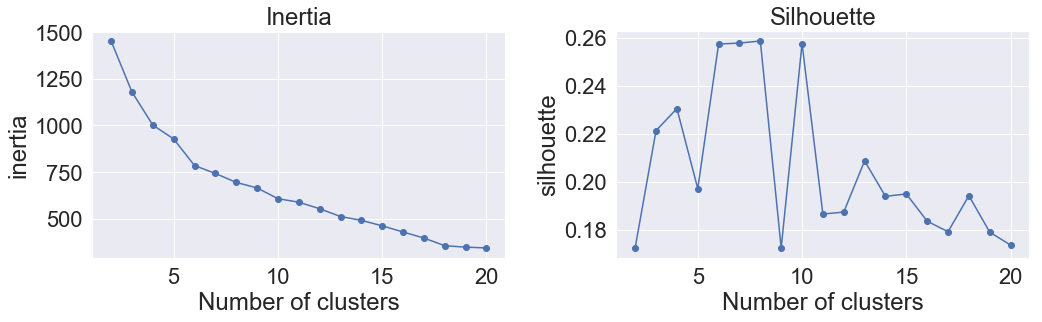

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(axis, inert, marker='o')
ax1.set(xlabel='Number of clusters', ylabel='inertia',title='Inertia')

ax2.plot(axis, sil, marker='o')
ax2.set(xlabel='Number of clusters', ylabel='silhouette',title='Silhouette')


plt.tight_layout()
plt.show()

In [9]:
#Apply Kmeans using optimal number of clusters
kmean = KMeans(n_clusters=6, init='k-means++')
cluster_labels = kmean.fit_predict(X)
centers = kmean.cluster_centers_



In [10]:
#Apply PCA and build new df for viz
num_components=3
pca = PCA(n_components=num_components)
p_comps = pca.fit_transform(X)
final=None
cols = ['PC{}'.format(i+1) for i in range(num_components) ]
final = pd.DataFrame(p_comps, columns=cols)
final['country'] = df_ctry_feat.index
final['cluster'] = cluster_labels



[[-1.89206245e-01 -2.65197161e-01  6.88514081e-02 -7.27814874e-02
   1.31428454e-01 -2.27732888e-01  3.19502569e-01 -1.03217905e-01
  -2.92359473e-02 -1.34665543e-01 -1.47908907e-01 -2.82582216e-01
  -2.01741644e-01 -1.07903376e-01 -3.20445725e-01 -2.97645123e-01
   2.74859542e-01 -2.89348961e-01 -3.20466095e-01 -4.88096494e-02
   3.64107018e-02 -1.64469447e-01 -1.48487406e-01 -9.26376208e-02
   1.19358126e-01  4.24554620e-03]
 [ 3.35409328e-01  1.60748746e-01 -1.57346504e-01  1.96919697e-01
  -2.56132058e-01  1.11334792e-01 -5.77835963e-02 -4.30814143e-02
  -3.76909966e-03  2.10064979e-01 -1.27359462e-01 -2.22398112e-02
   2.26223208e-01 -2.47119552e-01 -1.61326176e-01 -5.82782386e-02
   2.12099260e-01 -2.33126404e-01 -9.66081384e-02 -4.81218622e-02
  -1.09800255e-01 -3.22495935e-01  3.73562770e-01 -2.23255775e-01
  -1.24281558e-01 -2.83771553e-01]
 [-5.27185973e-02  2.48892148e-01  1.17139342e-02  3.98017824e-01
   1.57836775e-01 -2.02401970e-01 -3.66392367e-02 -1.86442498e-01
   1.6

In [11]:
#plot in a 3D scatter plot in order to vizually explore

import plotly.express as px

fig = px.scatter_3d(final, x='PC1', y='PC2', z='PC3', color='cluster',
                    hover_data=['country','cluster'], width=1000,
                    height=1000)
fig.update_layout(showlegend=False)
fig.show()

### Exploring Patterns of Individual Songs Using Hierarchical Clustering
Given that song genres tend to be hierarchical in nature, does agglomerative clustering provide more useful or accurate clusters?

C:\Users\Felip3\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\Users\Felip3\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



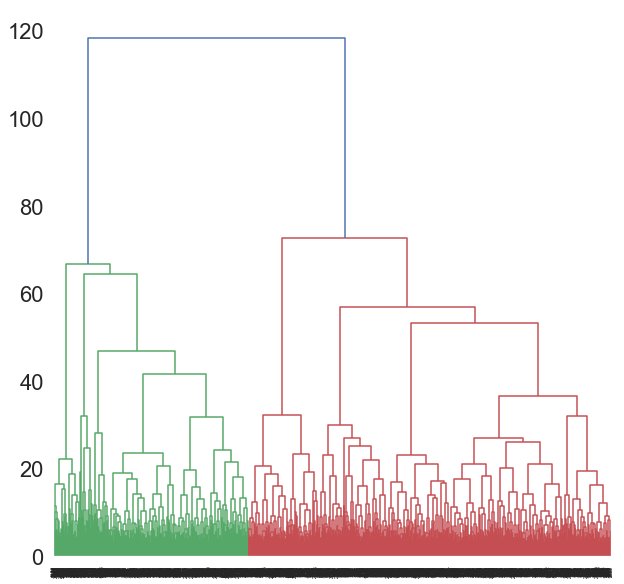

In [12]:
#Use a dendrogram to analyze the optimal number of clusters
X = scaler.fit_transform(df[features])

S = sch.linkage(X, method='ward')
fig=plt.figure(figsize=(10,10))
sch.dendrogram(S)

plt.show()

Generally, the longest vertical line in the dendrogram is used to identify the optimal number of clusters. However, since 3 clusters is likely too few, we'll take the second longest line. This provides us with 10 clusters.

In [13]:
#build and agglomerative clustering model and then plot on a 3D scatter plot
clusters = 10
num_components = 3
model = AgglomerativeClustering(n_clusters = clusters, affinity='euclidean', linkage='ward')
cluster_labels = model.fit_predict(X)
pca = PCA(n_components=num_components)
p_comps = pca.fit_transform(X)
final=None
cols = ['PC{}'.format(i+1) for i in range(num_components) ]
final = pd.DataFrame(p_comps, columns=cols)
final['cluster'] = cluster_labels

In [14]:
fig = px.scatter_3d(final, x='PC1', y='PC2', z='PC3', color='cluster',
                    hover_data=['cluster'], width=1000,
                    height=1000)
fig.update_layout(showlegend=False)
fig.show()

Since the above scatter plot is not helpful. We want to do some parameter tuning and see if adjusting the number of clusters provides better grouping. For the sake of comparison, we'll use 2 dimensions for PCA and plotting.

In [15]:
def get_clusters(df, num_clusters):
    clusters=num_clusters
    model = AgglomerativeClustering(n_clusters = clusters, affinity='euclidean', linkage='ward')
    model.fit(df)
    return model.labels_


In [16]:
def create_df(df, num_clusters, num_components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=num_components)
    p_comps = pca.fit_transform(df)
    final=None
    cols = ['PC{}'.format(i+1) for i in range(num_components) ]
    final = pd.DataFrame(p_comps, columns=cols)
    final['cluster'] = get_clusters(df, num_clusters)
    return final

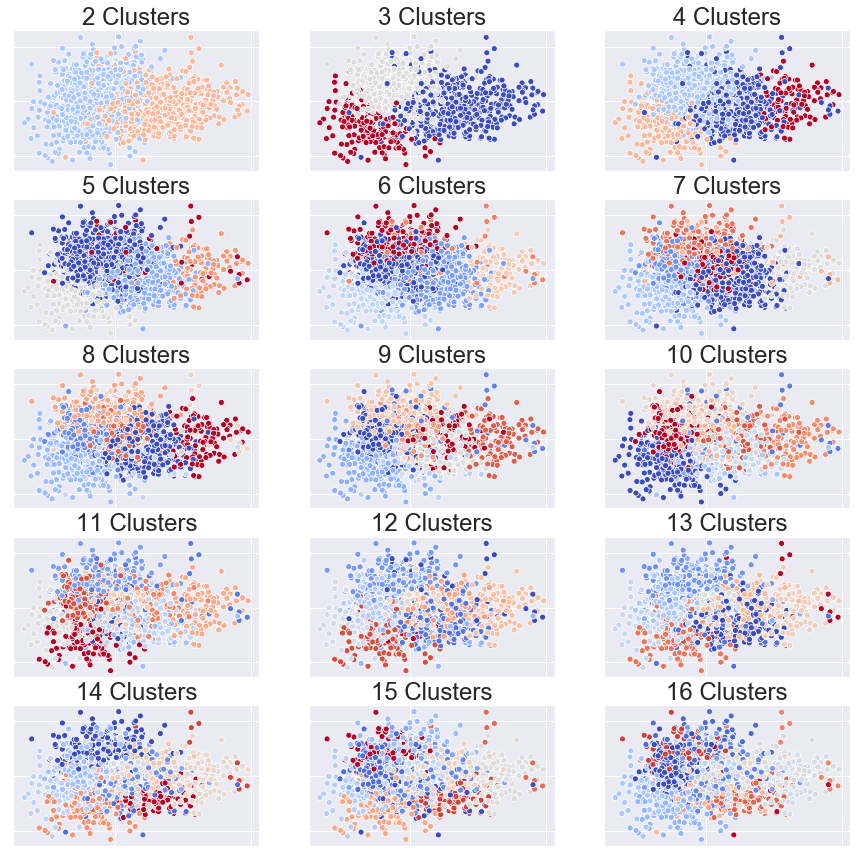

In [17]:
import seaborn as sns
num_clusters = 16
subs = num_clusters-1
cols = 3
# if plots
rows = subs//cols
rows += subs % cols
pos = range (1,subs)

fig, axs = plt.subplots(rows,cols,gridspec_kw={'width_ratios':[1 for i in range(cols)]},figsize=(15,15))

for ax,n in zip(axs.flatten(),range(2,num_clusters+1)):

    df = create_df(X, n, 2)
    sns.scatterplot(data = df, x='PC1', y='PC2', hue='cluster', palette='coolwarm', ax=ax, legend=False).set(
        xlabel=None,
        ylabel=None,
        xticklabels=[],
        yticklabels=[],
        title='{} Clusters'.format(n)
        )
plt.show()

No matter the number of cluster, there don't appear to be distinct, clearly delineated groups. Best stick to K-Means by country clustering.